In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import time

In [2]:
#run this in order to keep many decimals of the weight when normalized!
pd.set_option('precision', 12)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

In [3]:
def make_database(amino):#aminos):
    #aminos is taken as input so that only the "interesting" aminoacid are considered.

    
    path = 'database_csv/%s.csv' % amino
    df = pd.read_csv(path)
    df.columns = ['aa', 'phi', 'psi']
        
    df = df.drop('aa', axis =1)
    df['weight'] = 1 /len(df.index) #normalized
    
    return df #IT'S GOOD, DON'T TOUCH

In [5]:
def read_rama(path):
    #firstly, we read the .xvg file and make a proper pandas dataframe
    data = open(path, 'r')
    rama = pd.read_csv(data, sep = '\s+')
    rama.columns = ['phi', 'psi', 'aa']

    #in rama.xvg data are organized as \phi \psi aa-num so we have to split the last index
    rama[['type', 'num']] = rama['aa'].str.split('-', 1, expand=True)

    #values sorted by amino acid so that computations can be faster to implement
    rama = rama.drop(['aa', 'num'], axis = 1).sort_values('type').reset_index(drop=True)

    aminos = rama['type'].unique()
    aa_dict = {amino: rama[rama['type'] == amino].drop('type', axis = 1).reset_index() for amino in aminos}
    
    #print(aa_dict)

    return aa_dict

In [6]:
def peso(phi, psi, dih, const, mult, beta):
    
    d2r = np.pi / 180
    
    gd_42 = (const[0] * ( 1 + np.cos(mult[0] * (psi * d2r) - (dih[0] * d2r))))
    gd_43 = (const[1] * ( 1 + np.cos(mult[1] * (phi * d2r) - (dih[1] * d2r))))        
    gd_44 = (const[2] * ( 1 + np.cos(mult[2] * (phi * d2r) - (dih[2] * d2r))))
    gd_45 = (const[3] * ( 1 + np.cos(mult[3] * (psi * d2r) - (dih[3] * d2r))))

    return np.exp(-1 * beta * (gd_42 + gd_43 + gd_44 + gd_45))

In [7]:
def make_weights(rama, dih, const, mult, beta):

    rama = rama.assign(weight=lambda x: peso(x.phi, x.psi, dih, const, mult, beta))
    
    rama['weight'] = rama['weight'] / np.sum(rama['weight'])
    
    
    #print(rama)
        
    return rama


In [8]:
def make_matrix(df):
    #we create a second dictionary, parallel to the first. now the entries will be the matrices of frequencies
    mat, x1, x2 = np.histogram2d(df['psi'], df['phi'], bins=180, weights=df['weight'], density=True)
    
    return mat

In [9]:
dih_ala = [80.240, 164.619, 145.747, -113.029]
const_ala = [1.077, 3.795, 3.551, 0.244]
mult_ala = [4, 2, 1, 2]
dih_gly = [156.675, -157.063, -56.358, 99.915]
const_gly = [0.521, 2.248, 0.011, 0.881]
mult_gly = [2, 1, 1, 3]
dih_pro = [66.066, 16.407, 41.779, 8.897]
const_pro = [1.363, 3.287, 1.116, 3.203]
mult_pro = [4, 5, 6, 2]
dih_all = [104.859, 179.646, 136.198, 174.196]
const_all = [1.919, 1.912, 1.955, 0.570]
mult_all = [6, 2, 2, 1]


dih_0 = [180, 0, 180, 0]
const_0 = [0,0,0,0]
mult_0 = [2,3,6,6]

In [10]:
def compare(rama_dict_old, rama_dict_new, amino):
    db = make_database(amino)
    rama_old = rama_dict_old[amino]
    rama_new = rama_dict_new[amino]

    dih_0 = [180, 0, 180, 0]
    const_0 = [0,0,0,0]
    mult_0 = [2,3,6,6]  

    rm_old = make_weights(rama_old, dih_0, const_0, mult_0, 1/2.801974031)
    rm_new = make_weights(rama_new, dih_0, const_0, mult_0, 1/2.801974031)

    mat_db, x1, x2 = np.histogram2d(db['psi'], db['phi'], bins=180, weights=db['weight'], density=True)
    mat_old, x3, x4 = np.histogram2d(rm_old['psi'], rm_old['phi'], bins=180, weights=rm_old['weight'], density=True)
    mat_new, x5, x6 = np.histogram2d(rm_new['psi'], rm_new['phi'], bins=180, weights=rm_new['weight'], density=True)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,20))

    ax1.imshow(mat_db, interpolation='nearest', origin='low', cmap='seismic')
    ax1.set_title('%s - Database' % amino)
    ax2.imshow(mat_old, interpolation='nearest', origin='low', cmap='seismic')
    ax2.set_title('%s - Old' % amino)
    ax3.imshow(mat_new, interpolation='nearest', origin='low', cmap='seismic')
    ax3.set_title('%s - New' % amino)
    plt.savefig('plots_3/%s_compare_3.png' % amino)

    return 0

In [11]:
def reweigth(rama_dict, amino, dih, const, mult):
    db = make_database(amino)
    rama = read_dict[amino]    

    dih_0 = [180, 0, 180, 0]
    const_0 = [0,0,0,0]
    mult_0 = [2,3,6,6]  

    rm_old = make_weights(rama, dih_0, const_0, mult_0, 1/2.801974031)
    rm_new = make_weights(rama, dih, const, mult, 1/2.801974031)

    mat_db, x1, x2 = np.histogram2d(db['psi'], db['phi'], bins=180, weights=db['weight'], density=True)
    mat_old, x3, x4 = np.histogram2d(rm_old['psi'], rm_old['phi'], bins=180, weights=rm_old['weight'], density=True)
    mat_new, x5, x6 = np.histogram2d(rm_new['psi'], rm_new['phi'], bins=180, weights=rm_new['weight'], density=True)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,20))

    ax1.imshow(mat_db, interpolation='nearest', origin='low', cmap='seismic')
    ax1.set_title('%s - Database' % amino)
    ax2.imshow(mat_old, interpolation='nearest', origin='low', cmap='seismic')
    ax2.set_title('%s - Simulation' % amino)
    ax3.imshow(mat_new, interpolation='nearest', origin='low', cmap='seismic')
    ax3.set_title('%s - Best guess' % amino)
    plt.savefig('plots_3/%s_reweight_3.png' % amino)

    return 0

In [12]:
rama_dict_old = read_rama('input/rama_diff_2.xvg')
rama_dict_new = read_rama('input/rama_diff_4.xvg')

0

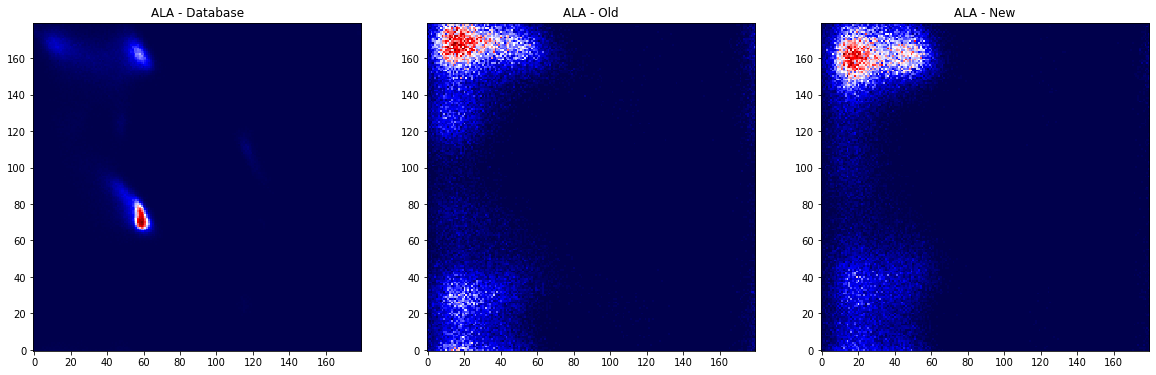

In [13]:
compare(rama_dict_old, rama_dict_new, 'ALA')

0

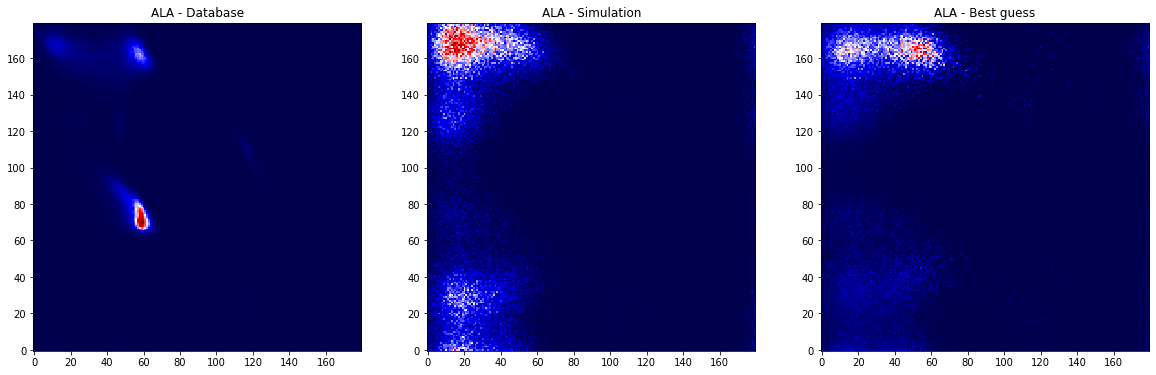

In [39]:
dih_ala = [5.664814, 52.821581, -132.040958, 67.512893]
const_ala = [0.200171, 0.715742, 2.765005, 1.468128]
mult_ala = [6, 2, 1, 2]
reweigth('input/rama_diff_2.xvg', 'ALA', dih_ala, const_ala, mult_ala)

0

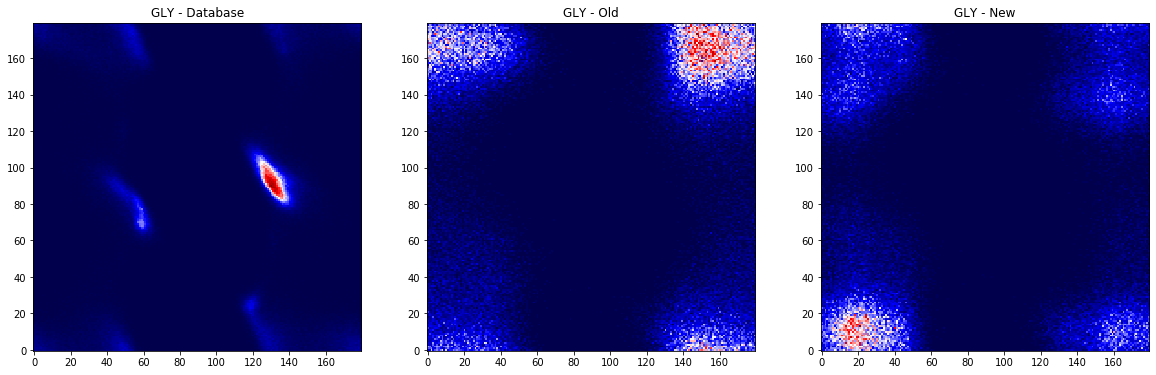

In [14]:
compare(rama_dict_old, rama_dict_new, 'GLY')

0

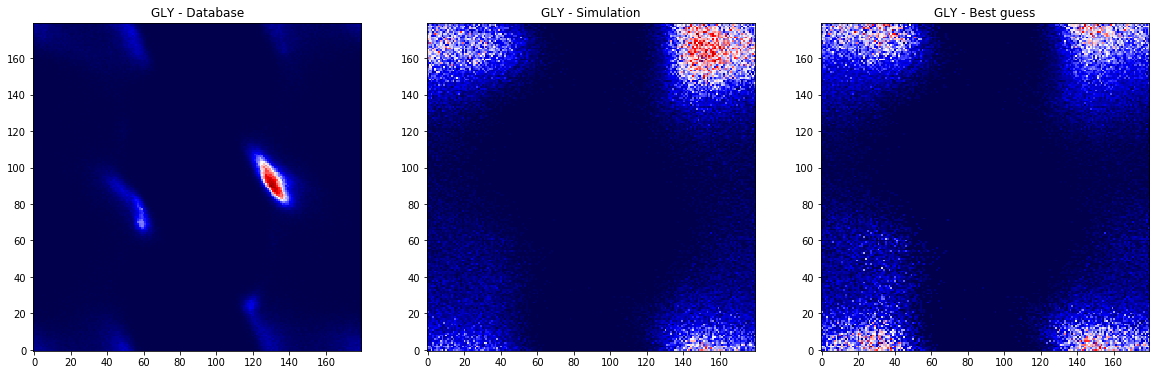

In [41]:
dih_gly = [90.923860, 156.480736, 85.377093, 46.236414]
const_gly = [1.050392, 1.029656, 0.347207, 0.618773]
mult_gly = [1, 1, 1, 3]
reweigth('input/rama_diff_2.xvg', 'GLY', dih_gly, const_gly, mult_gly)

0

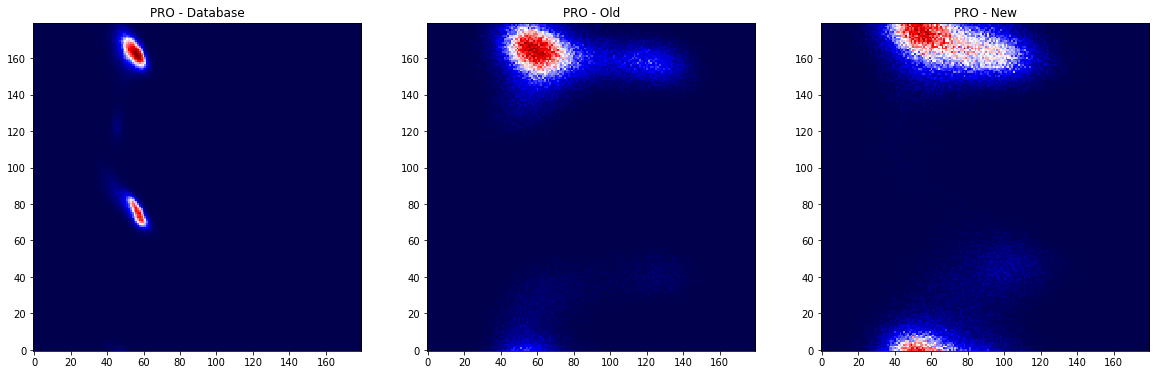

In [15]:
compare(rama_dict_old, rama_dict_new, 'PRO')

0

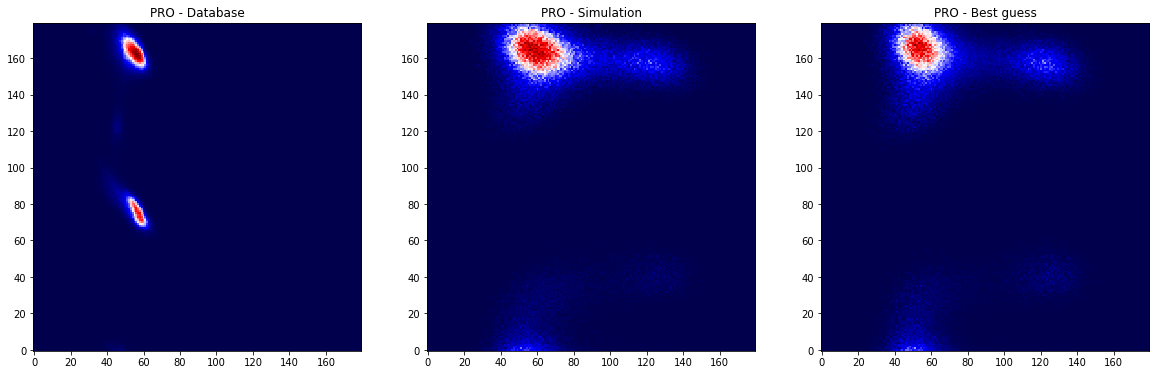

In [43]:
dih_pro = [-28.837195, 50.847218, -110.796150, -27.445549]
const_pro = [0.254768, 0.787630, 1.172506, 0.714172]
mult_pro = [3, 5, 6, 2]
reweigth('input/rama_diff_2.xvg', 'PRO', dih_pro, const_pro, mult_pro)

0

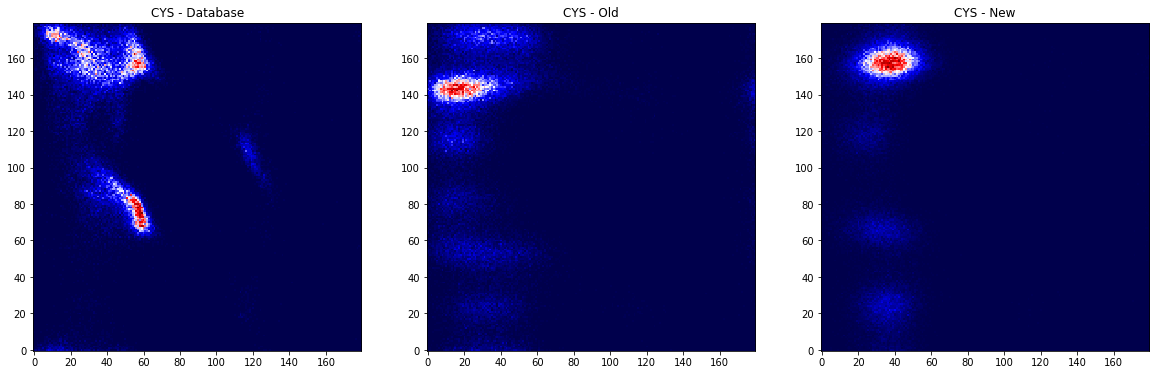

In [16]:
compare(rama_dict_old, rama_dict_new, 'CYS')

0

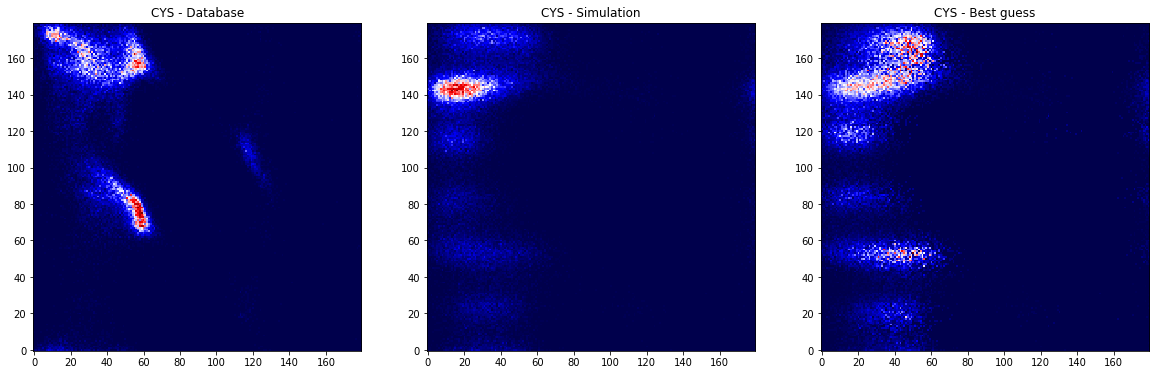

In [45]:
dih_all = [152.161454, 177.746838, 23.084979, -143.846]
const_all = [1.615288, 1.802139, 3.122620, 0.386776]
mult_all = [5, 2, 2, 1]
reweigth('input/rama_diff_2.xvg', 'CYS', dih_all, const_all, mult_all)

0

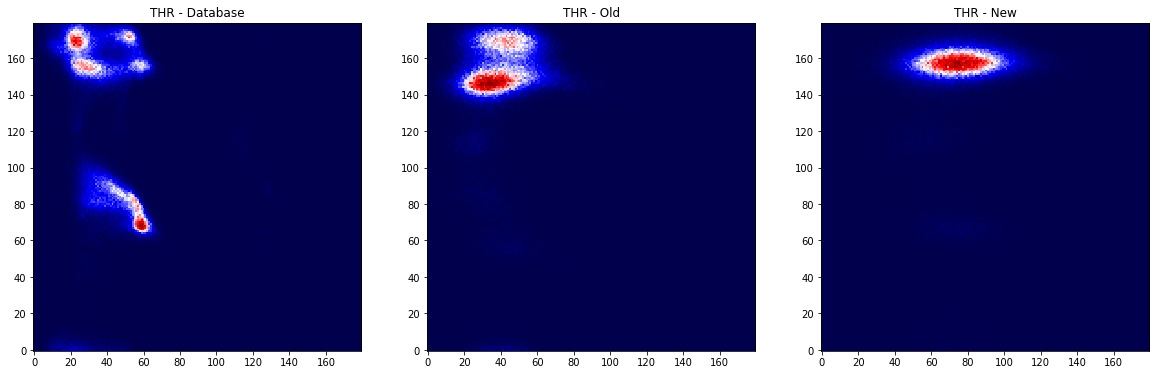

In [17]:
compare(rama_dict_old, rama_dict_new, 'THR')

0

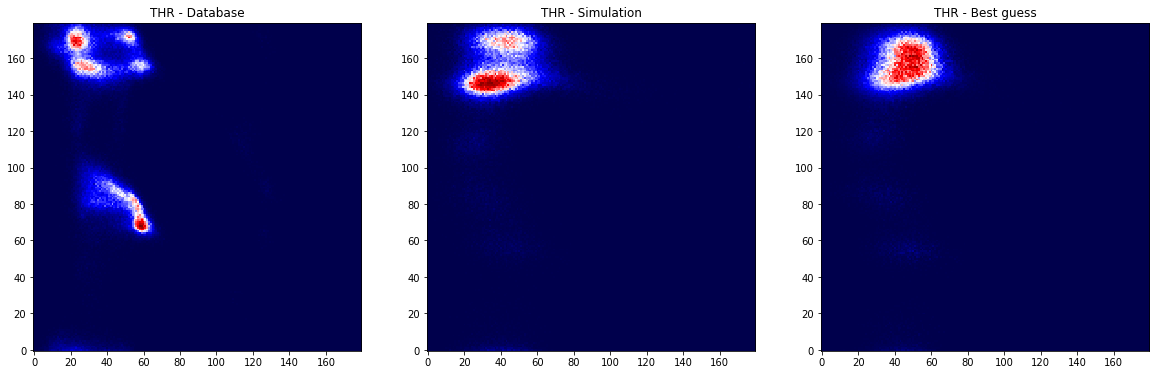

In [68]:
reweigth('input/rama_diff_2.xvg', 'THR', dih_all, const_all, mult_all)

0

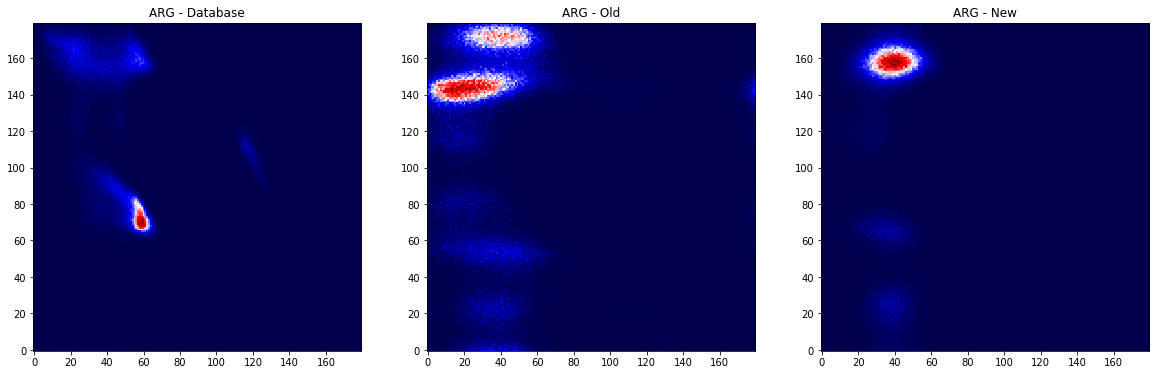

In [18]:
compare(rama_dict_old, rama_dict_new, 'ARG')

0

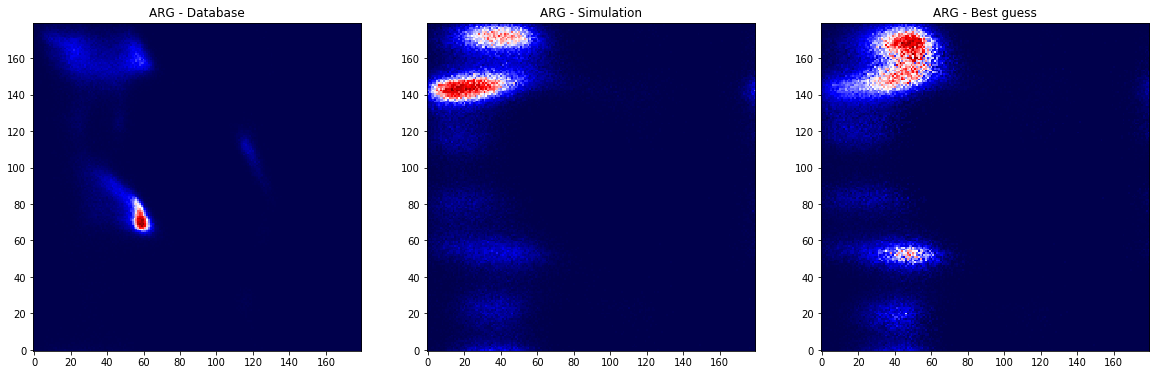

In [67]:
reweigth('input/rama_diff_2.xvg', 'ARG', dih_all, const_all, mult_all)

0

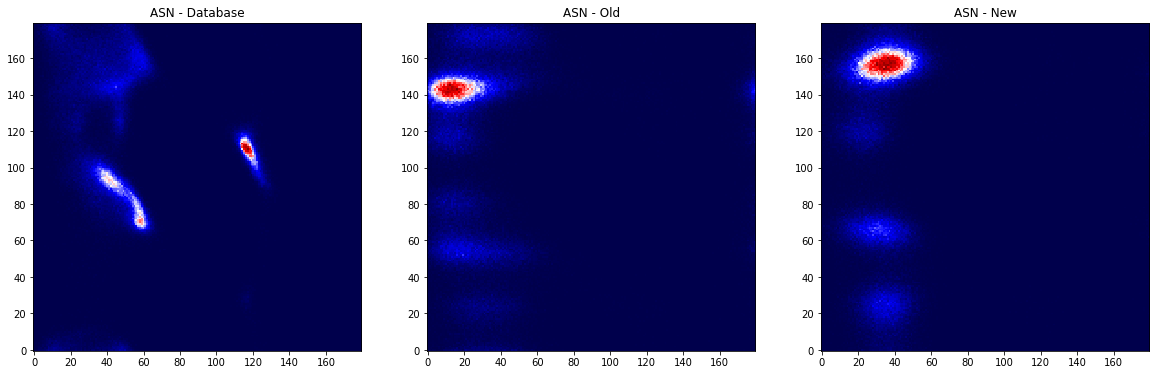

In [19]:
compare(rama_dict_old, rama_dict_new, 'ASN')

0

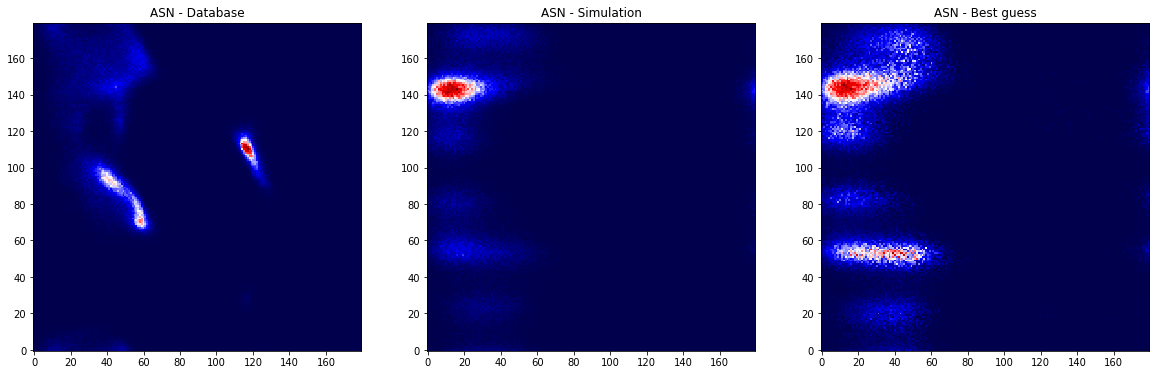

In [70]:
reweigth('input/rama_diff_2.xvg', 'ASN', dih_all, const_all, mult_all)

0

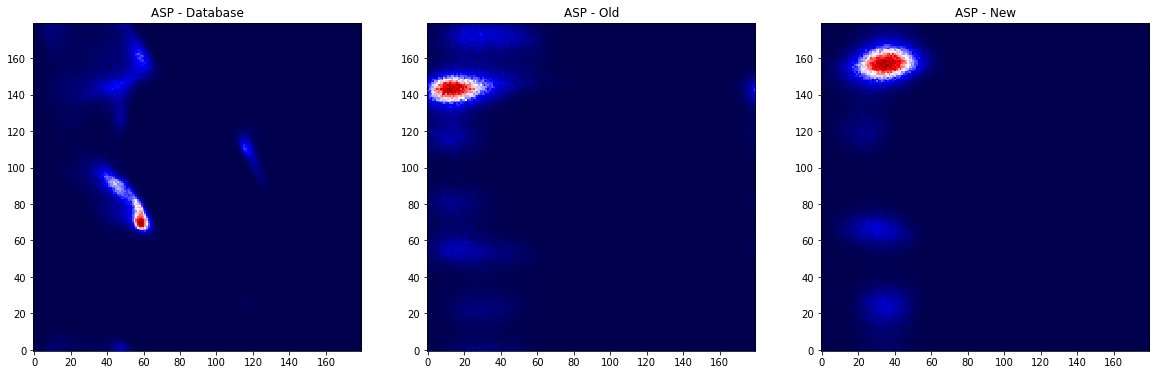

In [20]:
compare(rama_dict_old, rama_dict_new, 'ASP')

0

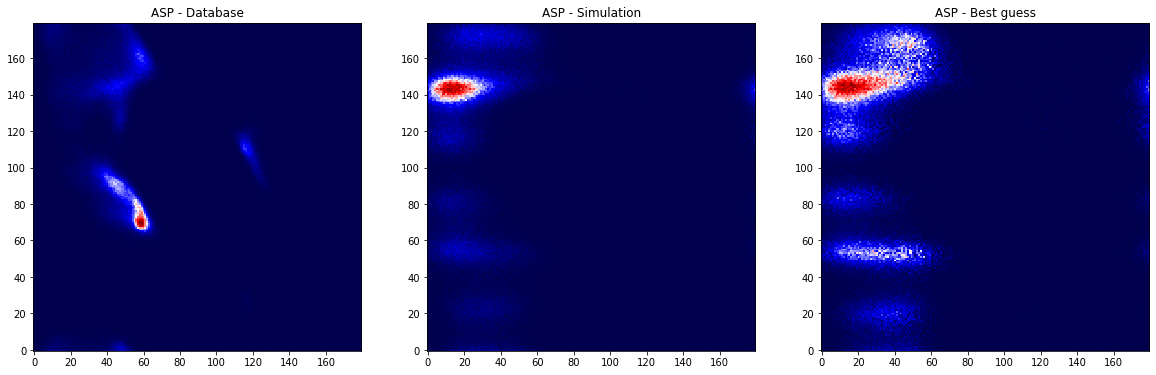

In [71]:
reweigth('input/rama_diff_2.xvg', 'ASP', dih_all, const_all, mult_all)

0

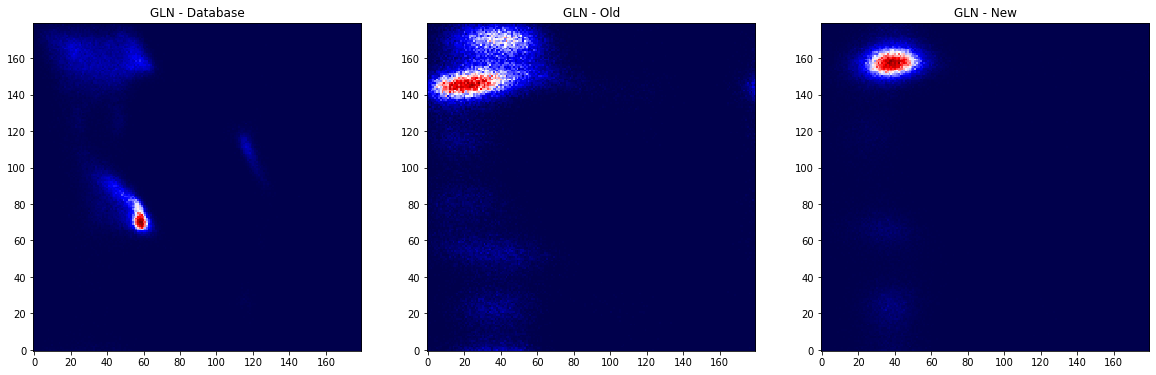

In [21]:
compare(rama_dict_old, rama_dict_new, 'GLN')

0

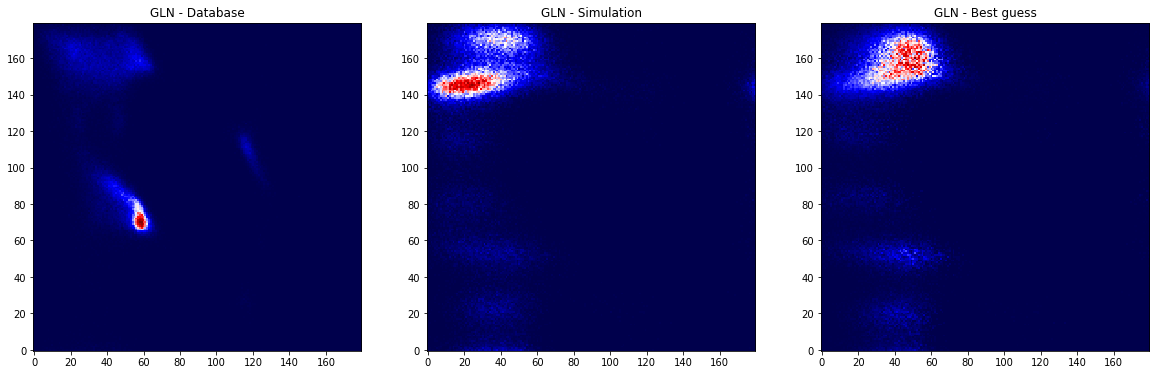

In [72]:
reweigth('input/rama_diff_2.xvg', 'GLN', dih_all, const_all, mult_all)

0

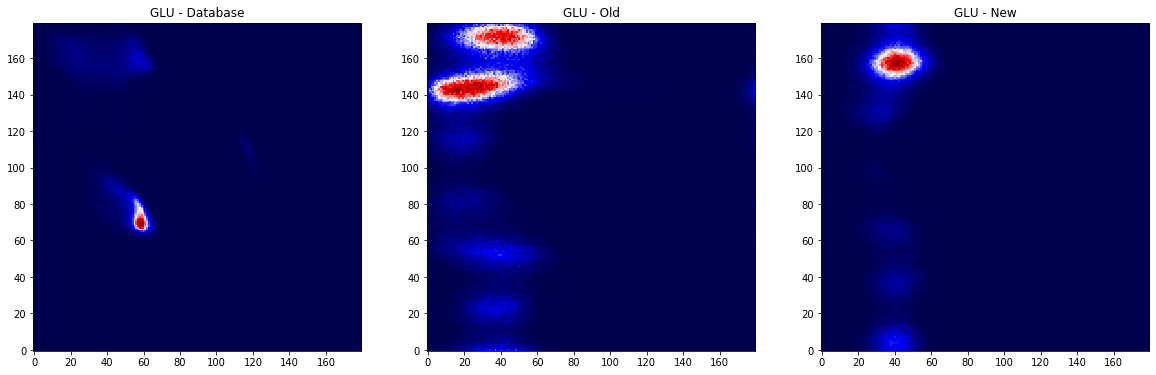

In [115]:
compare('input/rama_diff_2.xvg', 'input/rama_diff_3.xvg', 'GLU')

0

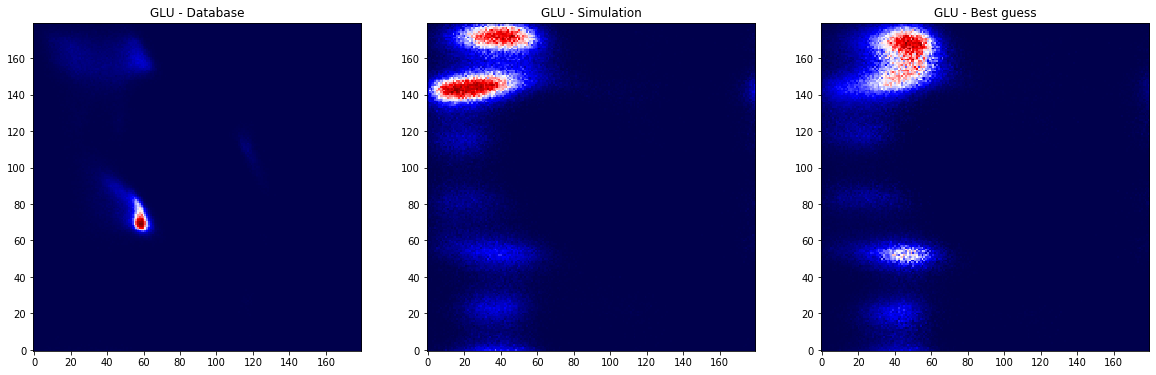

In [74]:
reweigth('input/rama_diff_2.xvg', 'GLU', dih_all, const_all, mult_all)

0

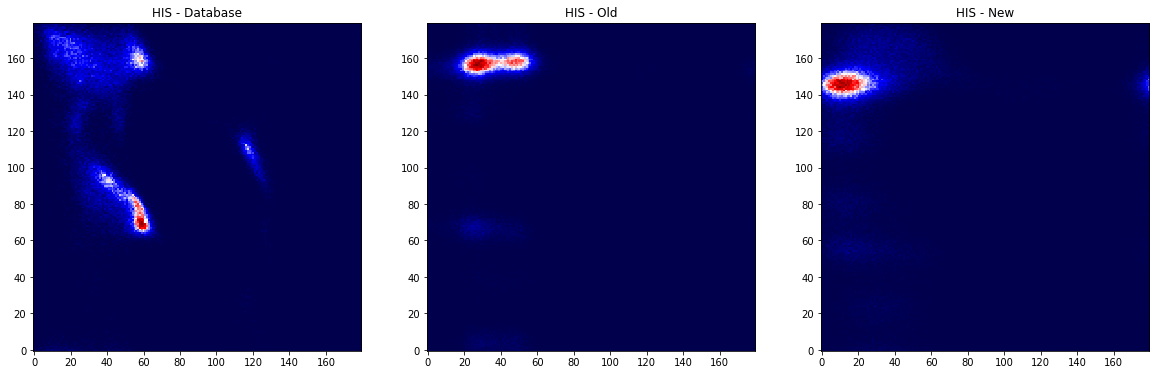

In [75]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'HIS')

0

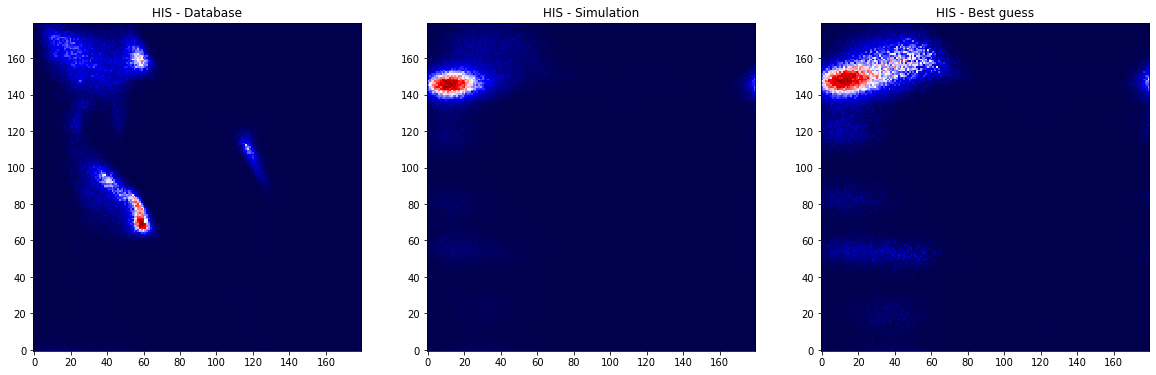

In [76]:
reweigth('input/rama_diff_2.xvg', 'HIS', dih_all, const_all, mult_all)

0

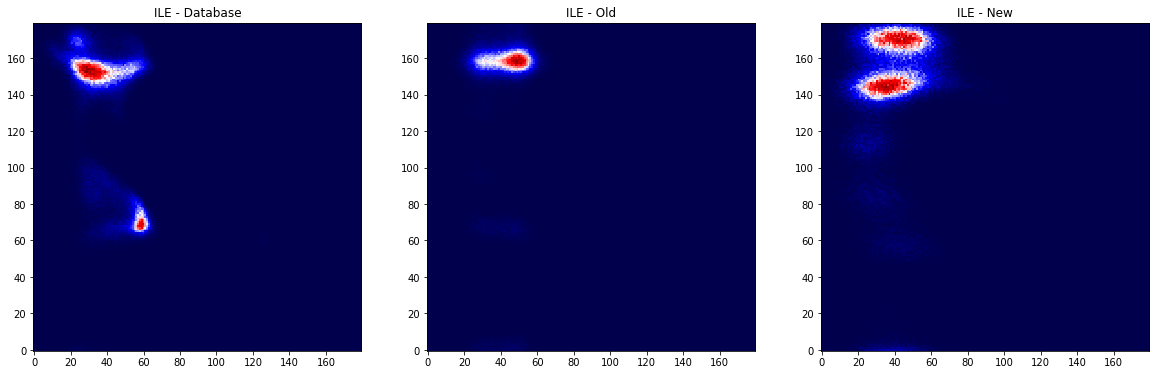

In [102]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'ILE')

0

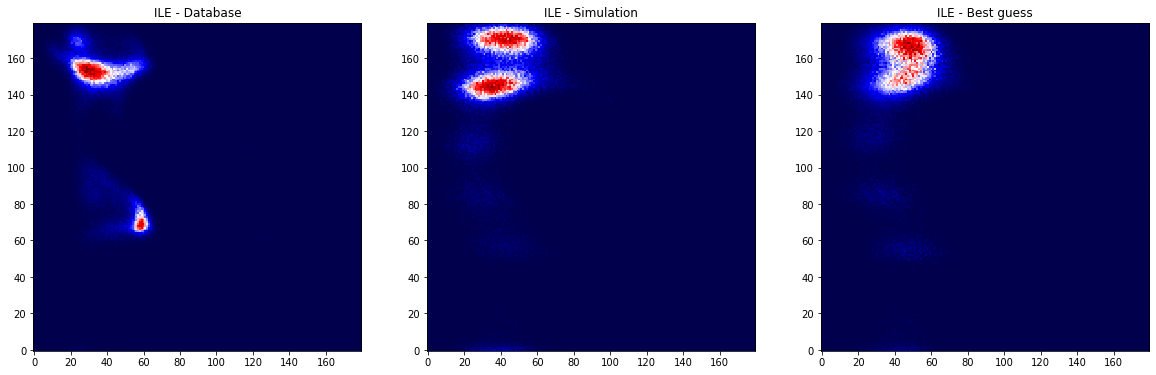

In [78]:
reweigth('input/rama_diff_2.xvg', 'ILE', dih_all, const_all, mult_all)

0

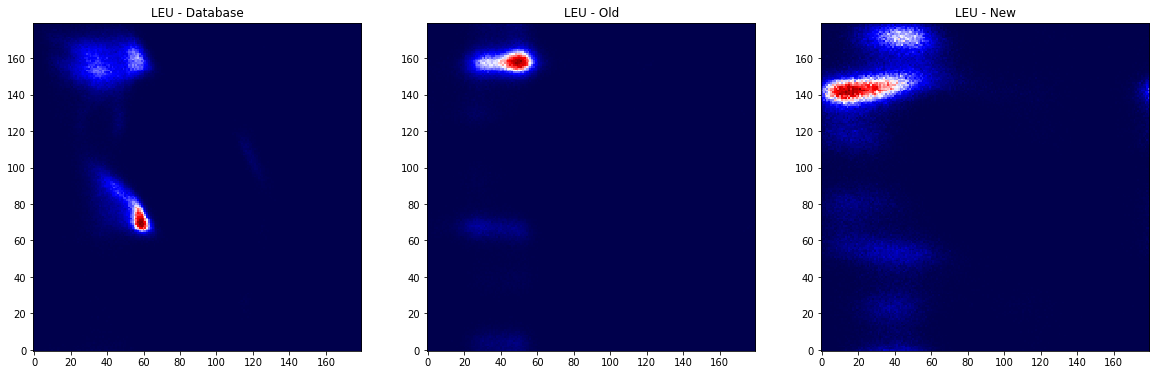

In [103]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'LEU')

0

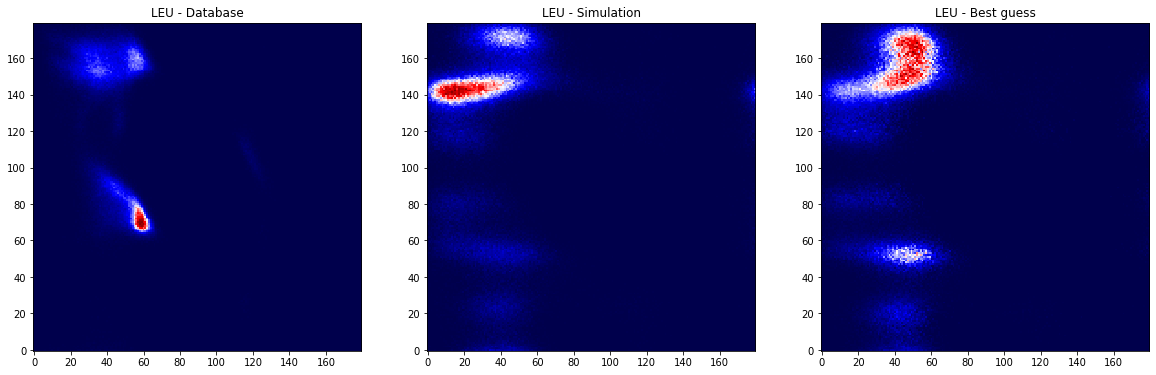

In [79]:
reweigth('input/rama_diff_2.xvg', 'LEU', dih_all, const_all, mult_all)

0

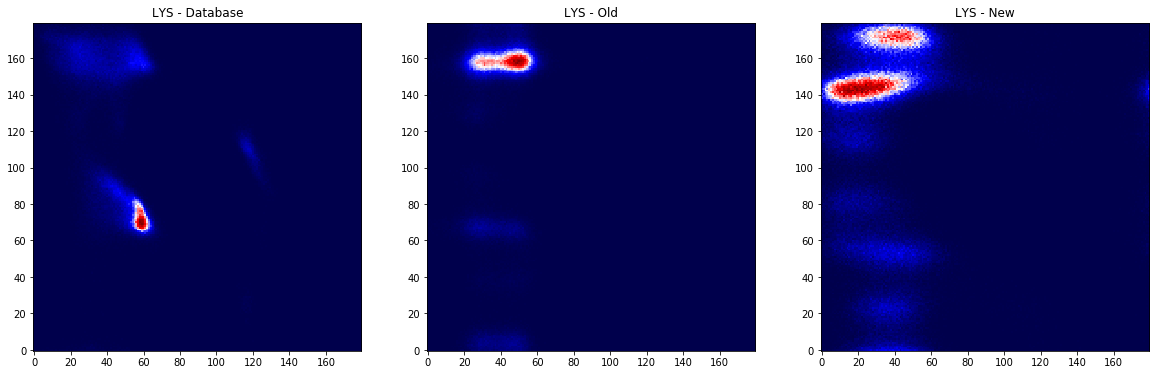

In [95]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'LYS')

0

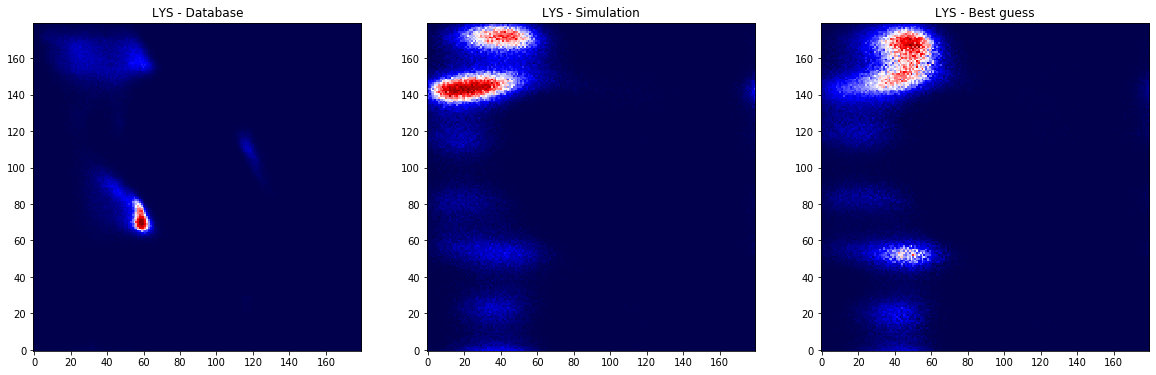

In [80]:
reweigth('input/rama_diff_2.xvg', 'LYS', dih_all, const_all, mult_all)

0

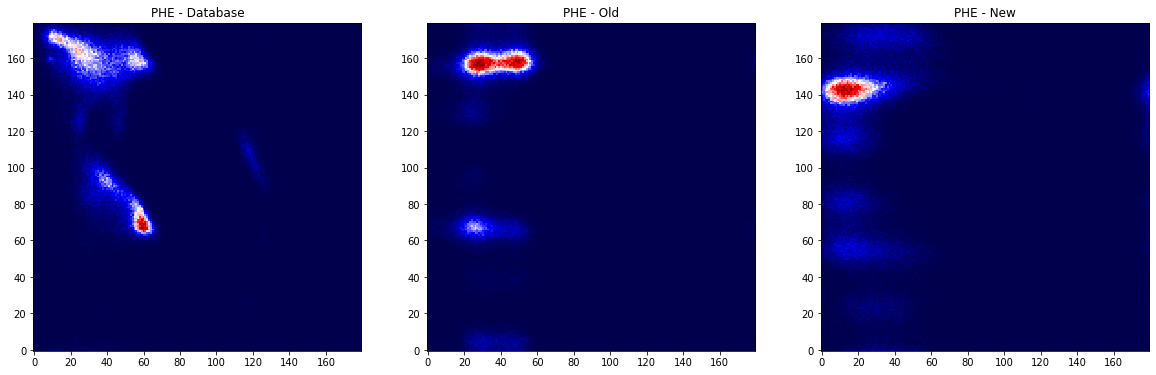

In [96]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'PHE')

0

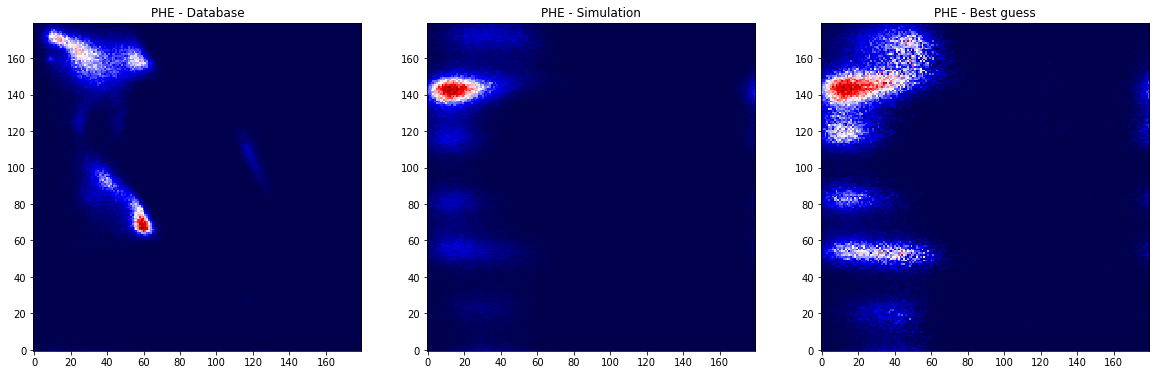

In [77]:
reweigth('input/rama_diff_2.xvg', 'PHE', dih_all, const_all, mult_all)

0

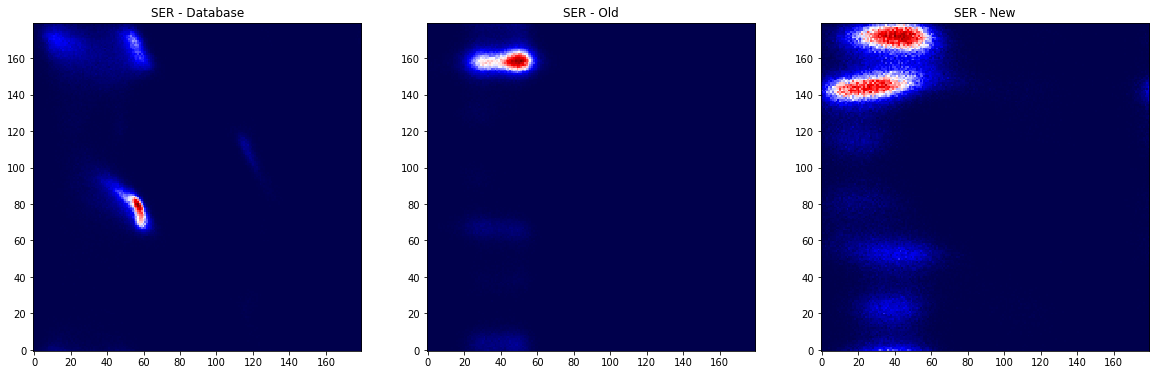

In [97]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'SER')

0

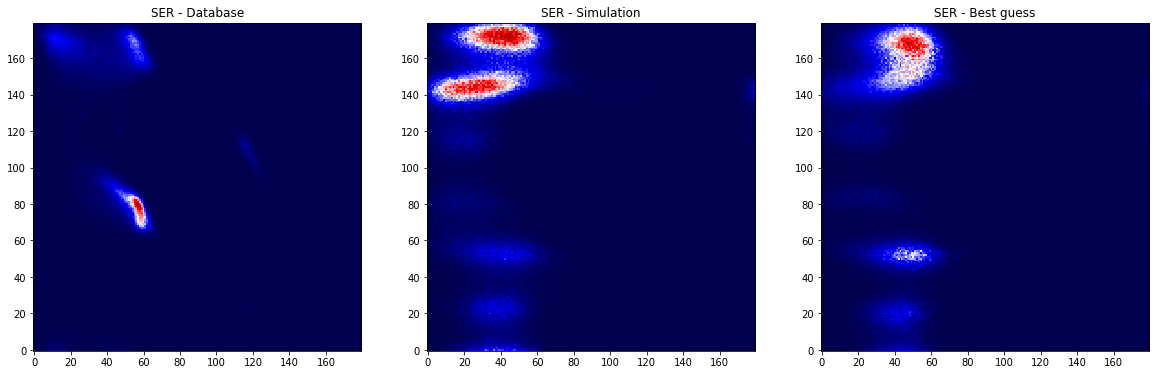

In [81]:
reweigth('input/rama_diff_2.xvg', 'SER', dih_all, const_all, mult_all)

0

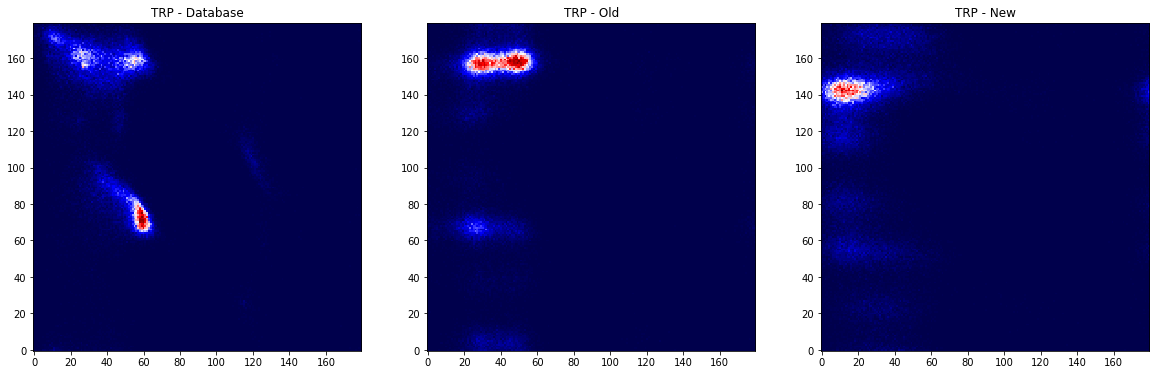

In [98]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'TRP')

0

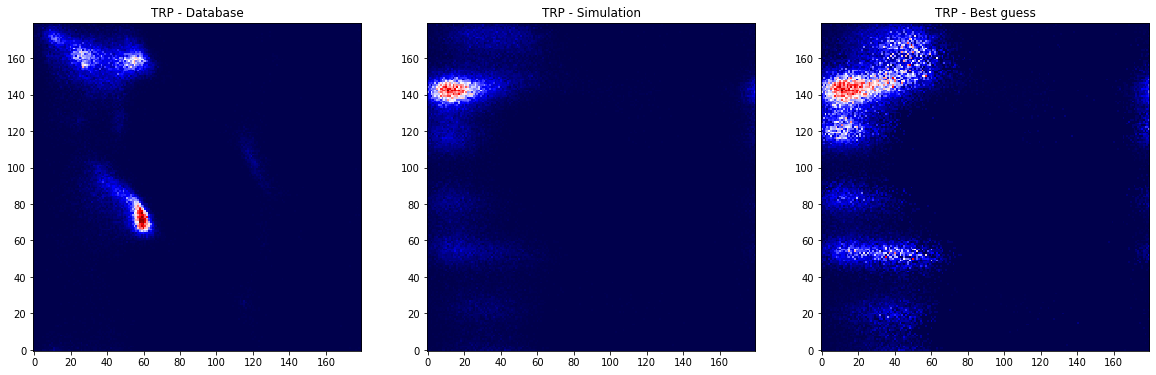

In [82]:
reweigth('input/rama_diff_2.xvg', 'TRP', dih_all, const_all, mult_all)

0

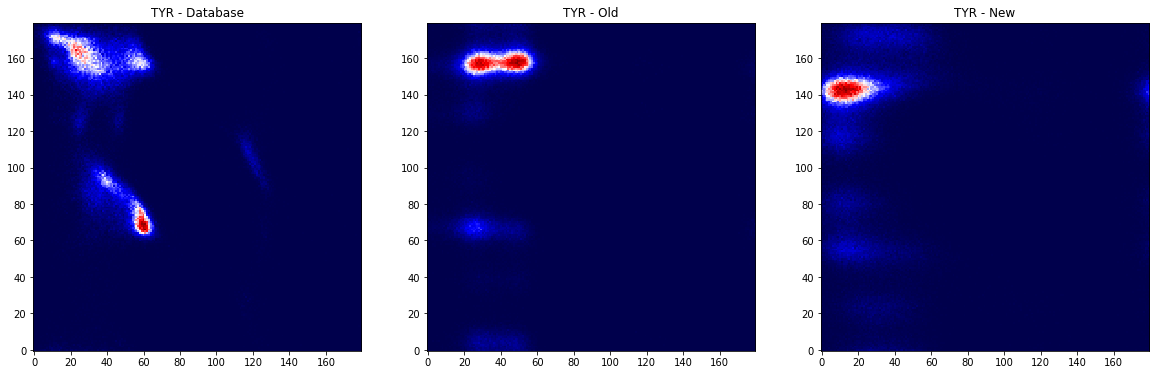

In [99]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'TYR')

0

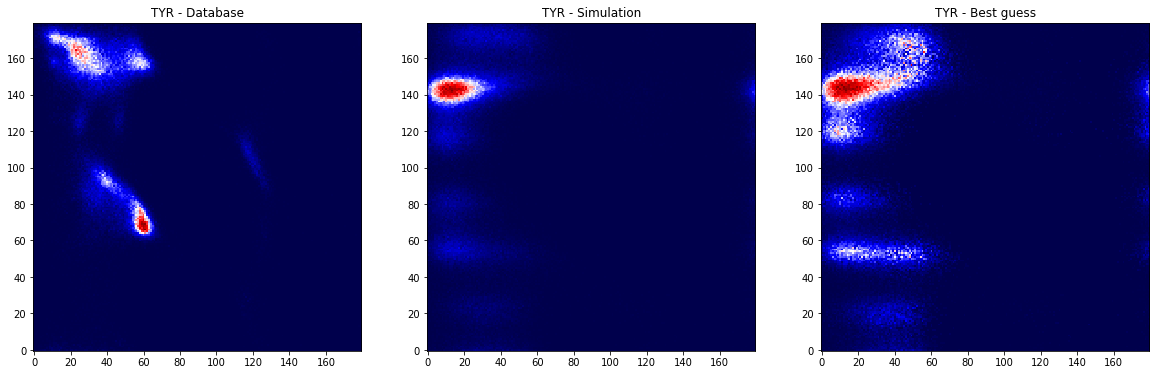

In [83]:
reweigth('input/rama_diff_2.xvg', 'TYR', dih_all, const_all, mult_all)

0

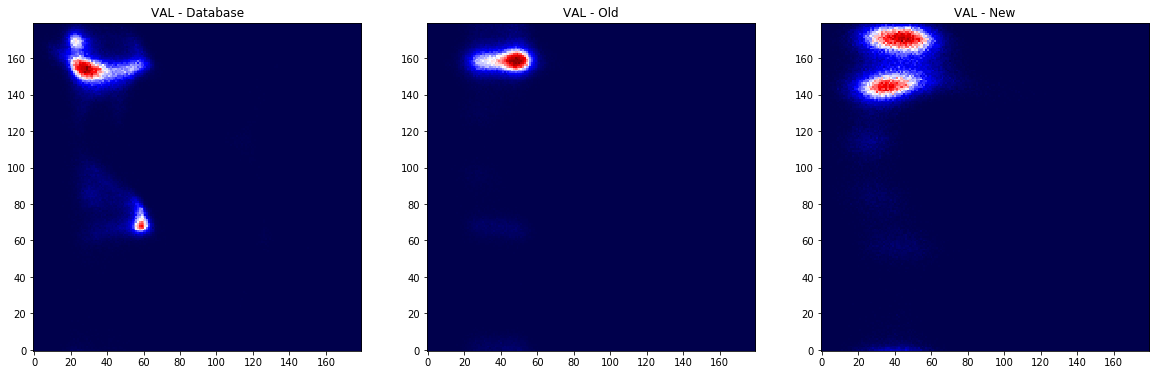

In [100]:
compare('input/rama_diff_1.xvg', 'input/rama_diff_2.xvg', 'VAL')

0

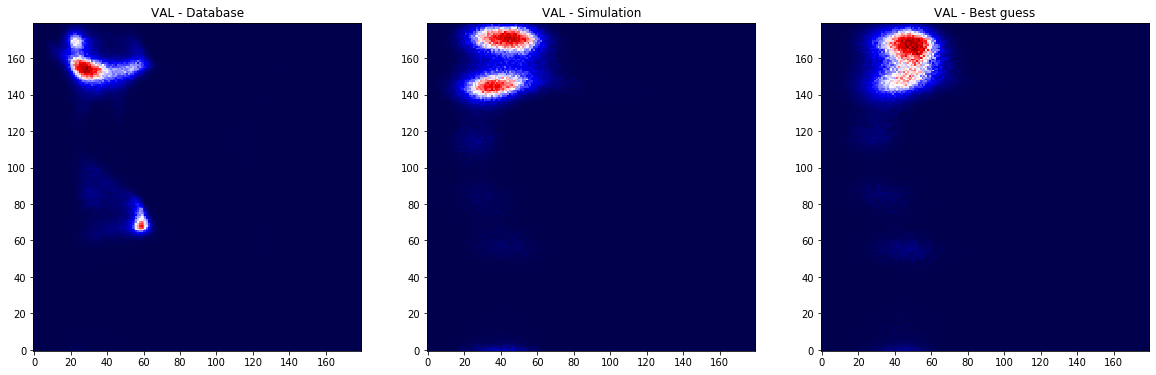

In [84]:
reweigth('input/rama_diff_2.xvg', 'VAL', dih_all, const_all, mult_all)